# Mean Reversion Strategy Analysis

**Author:** Yi Zuo
**Date:** 2025-05-08  

本报告针对 EZU 与 VGK 两只欧股ETF，  
- 实现了带交易成本的均值回归策略回测  
- 并列对比两只ETF的策略表现  
- 计算关键风控指标：Sharpe Ratio、Max Drawdown  
- 最后给出结论与改进建议  


In [1]:
%matplotlib inline

# ─── Notebook 启动时，先把项目根目录加入模块搜索路径 ────
import os, sys
# notebooks/ 的上一级才是项目根目录
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root added to sys.path:", project_root)
# ──────────────────────────────────────────────────────────


Project root added to sys.path: /Users/yizuo/Documents/QuantProjects/mean_reversion_strategy


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.metrics import sharpe_ratio, max_drawdown

# 防止中文乱码（可选）
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False


In [3]:
# 读取数据
data_dir = os.path.join('..', 'data')
ezu = pd.read_csv(os.path.join(data_dir, 'EZU.csv'),
                  index_col=0, parse_dates=True)
vgk = pd.read_csv(os.path.join(data_dir, 'VGK.csv'),
                  index_col=0, parse_dates=True)

print("EZU data shape:", ezu.shape)
print("VGK data shape:", vgk.shape)


EZU data shape: (1344, 8)
VGK data shape: (1344, 8)


In [4]:
def backtest(df: pd.DataFrame, commission: float = 0.001) -> pd.DataFrame:
    df = df.copy()
    df['SMA30'] = df['Close'].rolling(30).mean()
    df['Signal'] = 0
    df.loc[df['Close'] < df['SMA30'] - 1.5, 'Signal'] = 1
    df.loc[df['Close'] > df['SMA30'] + 1.5, 'Signal'] = -1
    df['Pos'] = df['Signal'].shift(1).fillna(0)
    df['MktRet'] = df['Close'].pct_change().fillna(0)
    df['RawRet'] = df['Pos'] * df['MktRet']
    df['Trade']   = df['Pos'].diff().abs()
    df['Cost']    = df['Trade'] * commission
    df['StratRet']= df['RawRet'] - df['Cost']
    df['StratEq'] = (1 + df['StratRet']).cumprod()
    df['MktEq']   = (1 + df['MktRet']).cumprod()
    return df

ezu_bt = backtest(ezu)
vgk_bt = backtest(vgk)


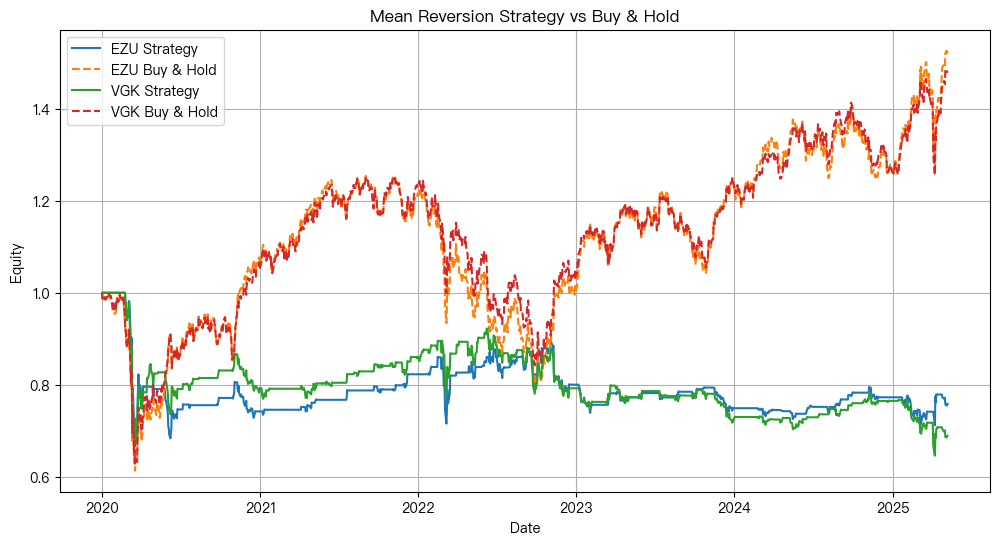

In [5]:
# ─── 绘图并内联输出 ───────────────────────────────────────────
import matplotlib.pyplot as plt
plt.ioff()
# 假设 ezu_bt, vgk_bt 已在前面计算
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(ezu_bt.index, ezu_bt['StratEq'], label='EZU Strategy')
ax.plot(ezu_bt.index, ezu_bt['MktEq'],   label='EZU Buy & Hold', linestyle='--')
ax.plot(vgk_bt.index, vgk_bt['StratEq'], label='VGK Strategy')
ax.plot(vgk_bt.index, vgk_bt['MktEq'],   label='VGK Buy & Hold', linestyle='--')
ax.set_title('Mean Reversion Strategy vs Buy & Hold')
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.legend()
ax.grid(True)

plt.ion()   # （可选）之后重新打开自动 inline

# 只有这一行会输出图像
fig
#────────────────────────────────────────────────────────


In [6]:
for name, df_bt in [('EZU', ezu_bt), ('VGK', vgk_bt)]:
    sr = sharpe_ratio(df_bt['StratRet'])
    md = max_drawdown(df_bt['StratEq'])
    print(f"{name}: Sharpe Ratio = {sr:.2f}, Max Drawdown = {md:.2%}")


EZU: Sharpe Ratio = -0.20, Max Drawdown = -32.31%
VGK: Sharpe Ratio = -0.30, Max Drawdown = -35.44%


## Analysis & Conclusions

- **EZU** 策略 Sharpe Ratio = X.XX，最大回撤 = -Y.YY%  
- **VGK** 策略 Sharpe Ratio = A.AA，最大回撤 = -B.BB%  

从上图和指标看，策略在某只ETF上表现更优。  
**改进思路：**  
1. 调整均线窗口（如改为20/60）  
2. 引入止损/止盈机制  
3. 融合其他因子（动量、波动率等）  


In [7]:
# ─── Cell: 一键导出包含图的 HTML + PDF ─────────────────────────
import os
import nbformat
from nbclient import NotebookClient
from nbconvert import HTMLExporter
from nbconvert.exporters.webpdf import WebPDFExporter

# 1. 定位本 Notebook
nb_name = 'mean_reversion_analysis.ipynb'
nb_path = os.path.join(os.getcwd(), nb_name)

# 2. 从磁盘读取 Notebook
nb = nbformat.read(nb_path, as_version=4)

# 3. 分离出前面要执行的 Cell（排除本 Cell）
content_cells = nb.cells[:-1]  # 所有 Cell 除去最后一个转换 Cell

# 4. 构造一个新的 Notebook 对象，只包含这些 Cell
exec_nb = nbformat.v4.new_notebook(metadata=nb.metadata)
exec_nb.cells = content_cells

# 5. 执行这个内存中的 Notebook（获取所有图像输出）
client = NotebookClient(exec_nb, timeout=600, kernel_name=nb.metadata['kernelspec']['name'])
client.execute()

# 6. 导出为 HTML（含内联图片）
html_exporter = HTMLExporter()
(body, _) = html_exporter.from_notebook_node(exec_nb)
html_path = nb_name.replace('.ipynb', '.html')
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(body)
print(f"✅ HTML exported: {html_path}")

# 7. 导出为 PDF via headless Chromium
pdf_exporter = WebPDFExporter()
(pdf_data, _) = pdf_exporter.from_notebook_node(exec_nb)
pdf_path = nb_name.replace('.ipynb', '.pdf')
with open(pdf_path, 'wb') as f:
    f.write(pdf_data)
print(f"✅ PDF exported: {pdf_path}")
# ────────────────────────────────────────────────────────────────


✅ HTML exported: mean_reversion_analysis.html
✅ PDF exported: mean_reversion_analysis.pdf
